# Tasks remaining 
1. Read survey papers and 2/3 research papers carefully to know methods and architectures that have worked for this task.

2. Implement a baseline supervised RGB to Depth regression model using a known architecture(such as an encoder-decoder architecture/U-net). Study the filters and diagnose the model.

3. Go through the codebases of proper pytorch research code, and see structure

4. Implement research papers, diagnose models, compare results, including unsupervised/semi-supervised models.

5. Report

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME
!git config --global user.email "arjun2000ashok@gmail.com"
!git config --global user.name "Arjun Ashok"

/content/drive/My Drive/Depth_Estimation


In [3]:
%ls

 data/                     experiments/   __pycache__/   test.py
'Depth Estimation.ipynb'   model/         README.md      utils.py


In [7]:
# !git add .
# !git commit -m 'data loader works'
# !git log

[master 0b97d43] displayed image from 50k set
 5 files changed, 65 insertions(+), 22 deletions(-)
 rewrite Depth Estimation.ipynb (89%)
 rewrite __pycache__/test.cpython-36.pyc (97%)
 rewrite model/__pycache__/dataloader.cpython-36.pyc (78%)
commit 0b97d43a4bb98e03f2061346b2d4f372796c14e7 (HEAD -> master)
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Mon Jul 6 09:12:46 2020 +0000

    displayed image from 50k set

commit 3a7a339b8df5b6ade7b6a3d29fe1a321be7ed9c5
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 11:57:19 2020 +0000

    displayed image

commit 0a0cdeb0cb9ea856ac29d8deff65f9a80053ff0c
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 10:54:54 2020 +0000

    dset works

commit 5567d5f0944f06f657e363d8a5c5f67ad078e35c
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:   Sun Jul 5 10:03:47 2020 +0000

    gitignore updated with zip

commit f4b339d6f4a4ffa6b408e370b6a21239bc918e3a
Author: Arjun Ashok <arjun2000ashok@gmail.com>
Date:  

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
from zipfile import ZipFile

def get_zip_file(path):
  input_zip = ZipFile(path)
  data = {name: input_zip.read(name) for name in input_zip.namelist()}
  return data

path = 'data/raw/nyu_data.zip'
data = get_zip_file(path)

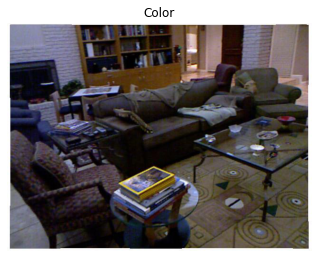

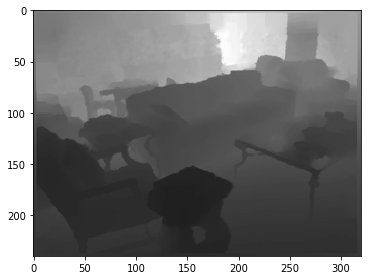

In [57]:
import test

test.main(data)